In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

#X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
#Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

X_motion_CoM = X_motion_CoM_acceleration
Y_motion_CoM = Y_motion_CoM_acceleration

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(5387, 27)
(5387, 3)


In [6]:
X_motion_CoM[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.22854666411876678,
       0.12870857119560242, -0.3830883204936981, 0.24612823128700256,
       -0.12833303213119507, -0.37785547971725464, -0.2489081770181656,
       0.12461630254983902, -0.38896113634109497, -0.269717276096344,
       -0.12609580159187317, -0.38343119621276855, 0.09078800678253174,
       -0.037348683923482895, 0.02203107438981533, 0.06813523918390274,
       0.04039946989656461, -0.01379605675012701, -0.02830420089540658,
       True, False], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(2698,)

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.22854666411876678,
       0.12870857119560242, -0.3830883204936981, 0.24612823128700256,
       -0.12833303213119507, -0.37785547971725464, -0.2489081770181656,
       0.12461630254983902, -0.38896113634109497, -0.269717276096344,
       -0.12609580159187317, -0.38343119621276855, 0.09078800678253174,
       -0.037348683923482895, 0.02203107438981533, 0.06813523918390274,
       0.04039946989656461, -0.01379605675012701, -0.02830420089540658,
       True, False], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.02672861137026078, 0.0011061801215013073, 0.0006479850081065885],
      dtype=object)

## Predict CoM -> x

### Linear Regression

In [15]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               #X_motion_CoM_FL_RR[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))0.04954298

R2:  0.9482842278514929
RMSE:  0.016257708679961916
The lowest error is:  3.107546831171426e-05
The highest error is:  0.0719034808003885
The avg. error is:  0.011467459127298232


In [16]:
model_fl_com_x.coef_

array([[ 2.13060674e-02,  1.66533454e-16, -1.66533454e-16,
         1.26510523e-01,  1.11022302e-16,  0.00000000e+00,
         8.81433170e-01, -1.09894961e+00,  1.34764628e-01,
         1.73731183e+00,  3.24921666e-01, -1.97849489e-01,
        -1.57214009e+00, -5.48487795e-02]])

In [17]:
model_fl_com_x.intercept_

array([-0.18221264])

In [18]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[-0.02578916]])

Text(0, 0.5, 'Predictions')

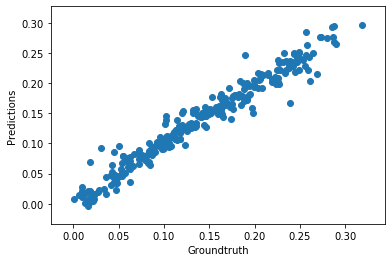

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [20]:
#%store model_fl_com_x

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [22]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [24]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               #X_motion_CoM_FL_RR[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.4848743936707606
RMSE:  0.0036156456567624806
The lowest error is:  7.403077669665414e-06
The highest error is:  0.01650620390631287
The avg. error is:  0.0027608754411847136


In [25]:
model_fl_com_y.coef_

array([[-7.73643348e-04,  1.21430643e-17, -1.89084859e-16,
         5.71629016e-03,  5.55111512e-17,  0.00000000e+00,
         1.57403343e-01, -4.36683840e-01,  4.62421340e-02,
         3.69007842e-01, -8.58004463e-02,  6.85656313e-02,
        -2.73385132e-01, -2.41320346e-01]])

In [26]:
model_fl_com_y.intercept_

array([-0.07975377])

Text(0, 0.5, 'Predictions')

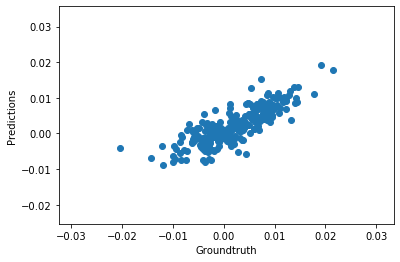

In [27]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [28]:
#%store model_fl_com_y

In [29]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [53]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [30]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               #X_motion_CoM_FL_RR[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.4303129964593241
RMSE:  0.0026041259840639077
The lowest error is:  3.403002061329319e-05
The highest error is:  0.008156107498638335
The avg. error is:  0.002061640219565486


In [31]:
model_fl_com_theta.coef_

array([[ 8.66616017e-04, -5.20417043e-17,  1.04083409e-17,
        -2.80629678e-03, -6.93889390e-17,  2.77555756e-17,
        -9.65734061e-02,  2.68956772e-02, -8.68206441e-03,
        -7.07644224e-02,  5.31667887e-02, -1.79432787e-01,
         2.03301137e-01,  1.15799332e-01]])

In [32]:
model_fl_com_theta.intercept_

array([0.11607478])

Text(0, 0.5, 'Predictions')

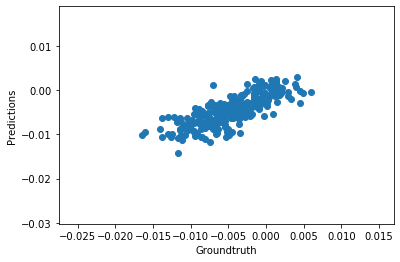

In [33]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")